In [1]:
import sys
sys.path.append("../")

from rbm import RBM
import utils
import analysis_methods as am

from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import math
import subprocess as sp
import matplotlib.image as mpimg

In [2]:
# Directory of Stored RBMs
mdir = "/mnt/D1/globus/exo_trained_rbms/"
rounds = ["exosome_st"]
data = ["exosome"]

#### Generate Weights

In [4]:
# generate weights in respective
# for rid, round in enumerate(rounds):
#     # if rid > 0:
#     #     break
checkp, version_dir = am.get_checkpoint_path(rounds[0], rbmdir=mdir)
tmp = RBM.load_from_checkpoint(checkp)
utils.all_weights(tmp, version_dir+rounds[0])

../utils.py:827: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks(xticks, xtickslabels)


In [5]:
import os
os.getcwd()

'/home/jonah/PycharmProjects/phage_display_ML/rbm_torch/analysis'

In [4]:
def assign(x):
    if x < 5:
        return "N" # low
    elif x < 20:
        return "L" # medium
    else:
        return "H" # High

# Stores all data in a dictionary ("data")
all_data = am.fetch_data(data, dir="../../datasets/exo/", assignment_function=assign, threads=12)

Process Time 2.6034162044525146


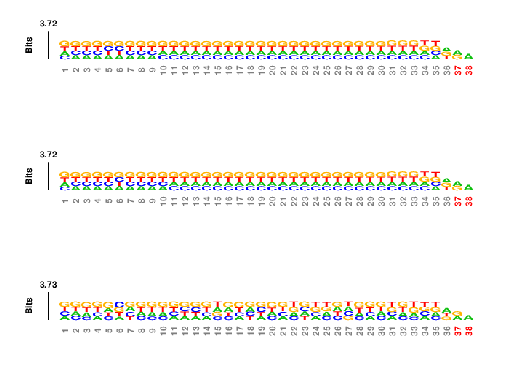

In [39]:
fig, axs = plt.subplots(3, 1)
for aid, a in enumerate(["N", "L", "H"]):
    assignment_map = all_data["assignment"] == a
    path = am.seq_logo(all_data[assignment_map], f"exo_{a}_seq_logo", outdir="./generated/")
    am.seqlogo_subplot(axs[aid], path)
plt.show()

In [11]:
# Generate Sequence Logo for Each round
paths_u, paths_w = [], []
# for r in rounds:
r = "exosome"
paths_u.append(am.seq_logo(all_data[all_data["round"] == r], f"{r}_seqlogo", weight=False, outdir="./generated/"))
paths_w.append(am.seq_logo(all_data[all_data["round"] == r], f"{r}_w_seqlogo", weight=True, outdir="./generated/"))

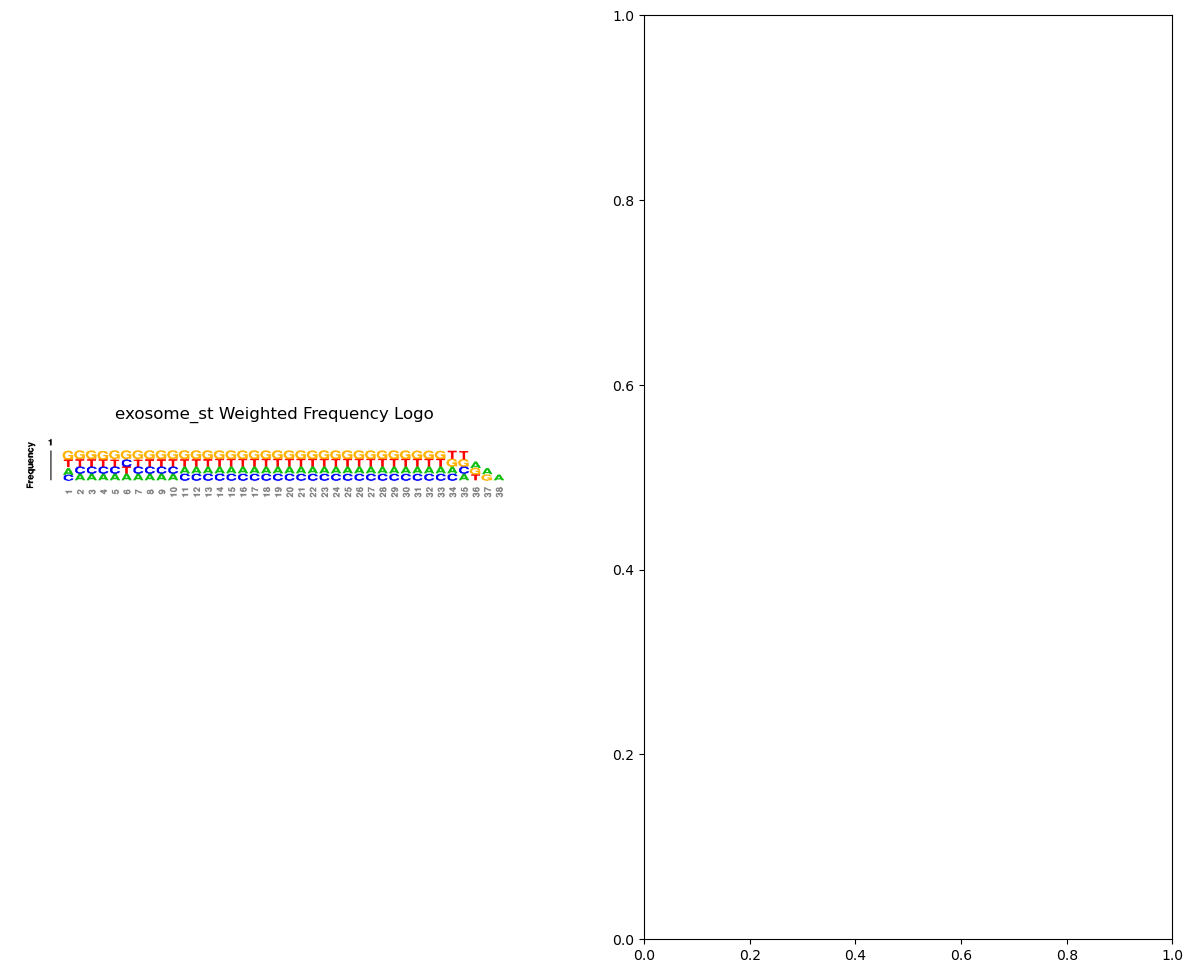

In [14]:
# Seq Logo showing Frequency of Each Amino Acid at each position
fig, axs = plt.subplots(len(rounds), 2)
fig.set_size_inches(15, 12)

for rid, r in enumerate(rounds):
    img1 = mpimg.imread(f"{paths_u[rid]}.freq.png")
    img2 = mpimg.imread(f"{paths_w[rid]}.freq.png")
    axs[rid].imshow(img1)
    axs[rid].imshow(img2)
    axs[rid].axis("off")
    axs[rid].axis("off")
    axs[rid].set_title(f"{r} Frequency Logo")
    axs[rid].set_title(f"{r} Weighted Frequency Logo")

plt.show()

In [5]:
# Low count == 1, Med count < 10, High count >= 10
# calculate likelihoods from last round rbm only
checkp, v_dir = am.get_checkpoint_path(rounds[0], rbmdir=mdir)
exo_rbm = RBM.load_from_checkpoint(checkp)

# this takes awhile, might be something I optimize further in the future
# am.generate_likelihoods(["exosome"], exo_rbm, all_data, "exo_st_rbm_v0")

In [6]:
exo_likelihoods = am.get_likelihoods("./generated/exo_st_rbm_v0.json")

In [7]:
all_data.index.__len__()

3380399

In [10]:
len(exo_likelihoods["likelihoods"]["exosome"])

3380399

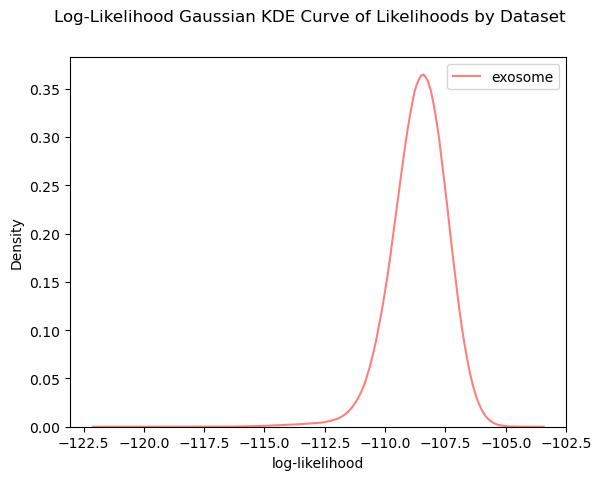

In [6]:
# Plot Likelihoods of Each batch of Data
am.plot_likelihoods(exo_likelihoods["likelihoods"], data, data, xlim=None, cdf=False)

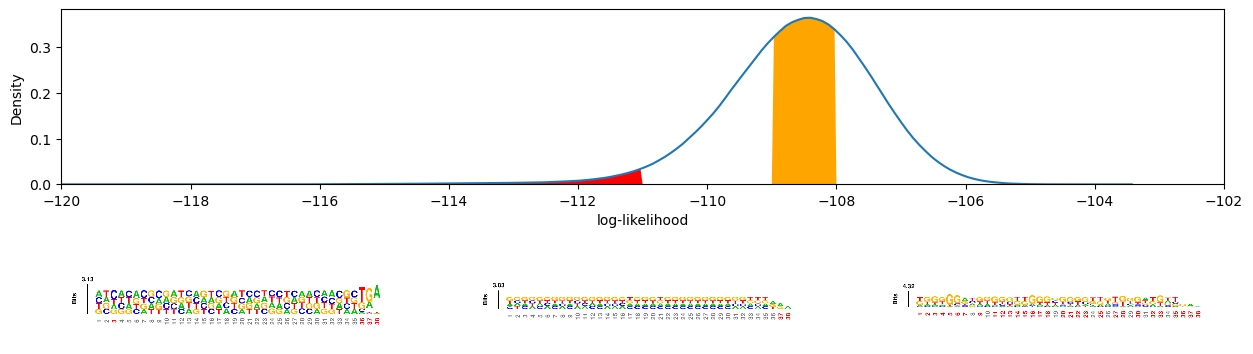

In [7]:
am.multi_peak_seq_log_fig(all_data, exo_likelihoods["likelihoods"], "exosome", [[-120, -111], [-109, -108], [-105, 0]], weight=False, xlim=(-120, -102))

##Clustering with the r12 RBM

Clustering by Inputs on hidden nodes

In [15]:
# Primary Component Analysis
from sklearn.decomposition import PCA
import clustering_methods as  cm
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import torch

def prepare_input_vector(rbm, dataframe, chunks=1):
    rbm.prep_W()
    if type(dataframe) == pd.DataFrame:
        base_to_id = am.int_to_letter_dicts[rbm.molecule]
        data_tensor = am.dataframe_to_input(dataframe, base_to_id, rbm.v_num, weights=False)
    elif type(dataframe) == torch.Tensor:
        data_tensor = dataframe
    if chunks > 1:
        number_of_seqs = data_tensor.shape[0] // chunks
        inputs = []
        for i in range(chunks):
            inputs.append(rbm.compute_output_v(data_tensor[number_of_seqs*i:number_of_seqs*(i+1)]))
        inputs.append(rbm.compute_output_v(data_tensor[number_of_seqs * chunks:]))
        input_hiddens = torch.cat(inputs, dim=0)
    else:
        input_hiddens = rbm.compute_output_v(data_tensor) # List of Iuk matrices
    return input_hiddens.detach().numpy()


exo_input = prepare_input_vector(exo_rbm, all_data, chunks=10)
scaler = StandardScaler()
input_exo_processed = scaler.fit_transform(exo_input)
X_exo = input_exo_processed

In [16]:
exo_input.shape

(3380399, 50)

In [17]:
X_exo.shape

(3380399, 50)

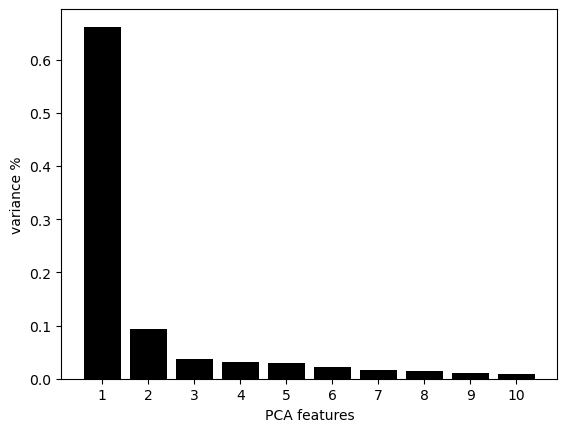

In [18]:
import clustering_methods as cm

cm.pca_component_check(X_exo, components=10)

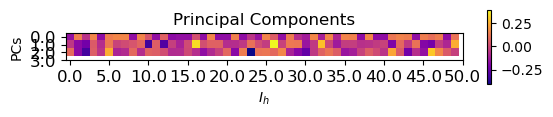

In [19]:
# We will do the first 4 components only, Drop in variance at feature 5
pca_exo = PCA(n_components=3)
principal_components = pca_exo.fit_transform(X_exo)
PCA_components_pd_exo = pd.DataFrame(principal_components)
components = pca_exo.components_
cm.view_components(components)

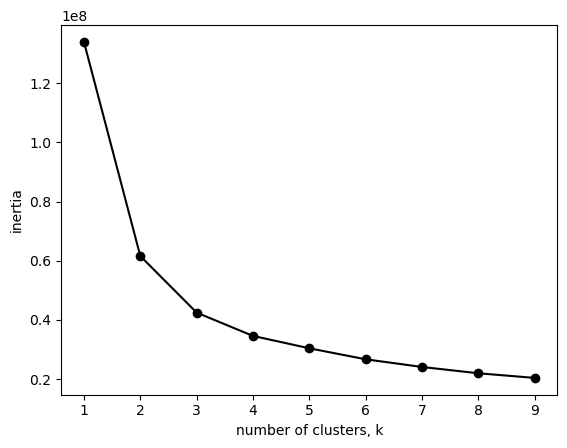

In [20]:
# KMeans on Transformed Sequences
from sklearn.cluster import KMeans

ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)

    # Fit model to samples
    model.fit(PCA_components_pd_exo.iloc[:, :3])

    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)

plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [22]:
# Elbow Point is at 5 so we will run it for 4 clusters
kmeans_pca = KMeans(n_clusters=3, init="k-means++", random_state=38)
kmeans_pca.fit(principal_components)
# Add principal components to dataframe
df_pca_kmeans = pd.concat([all_data.reset_index(drop=True), pd.DataFrame(principal_components)], axis=1)
df_pca_kmeans.columns.values[-3:] = ["Component 1", "Component 2", "Component 3"]
# Add labels from kmeans
df_pca_kmeans["K-mean PCA Label"] = kmeans_pca.labels_
# Replace integer with label in new column
df_pca_kmeans["Segment"] = df_pca_kmeans["K-mean PCA Label"].map({0:1, 1:2, 2:3, 3:4})

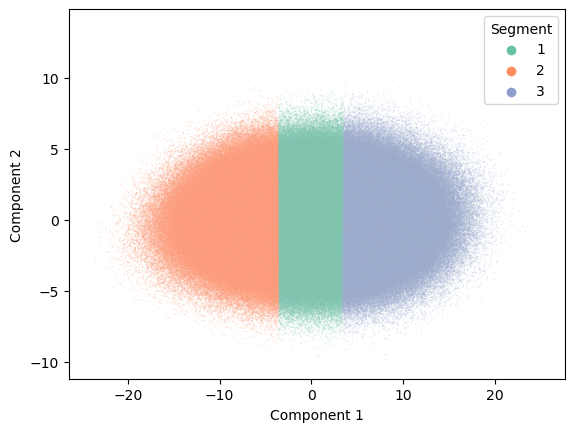

In [23]:
sns.scatterplot(data=df_pca_kmeans, x="Component 1", y="Component 2", hue="Segment", alpha=0.2, s=1, palette="Set2")
plt.show()

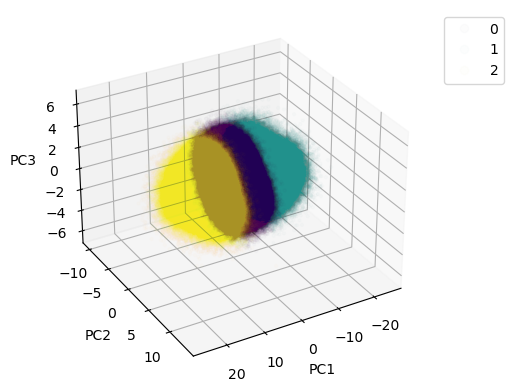

In [24]:
fig = plt.figure()
ax = plt.axes(projection='3d')
sc = ax.scatter(df_pca_kmeans["Component 1"], df_pca_kmeans["Component 2"], df_pca_kmeans["Component 3"], c=df_pca_kmeans["K-mean PCA Label"], alpha=0.01, marker=".")
ax.view_init(30, 60)  # Set viewing angle
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

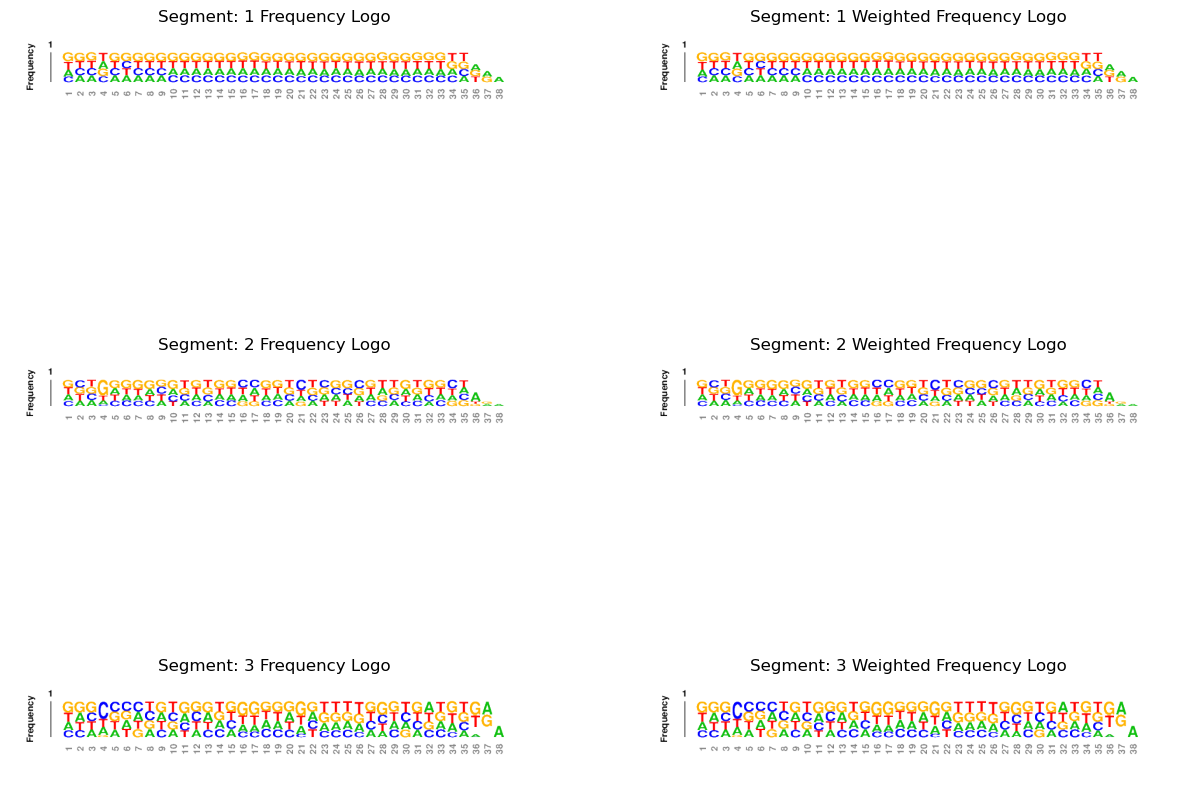

In [25]:
segments = [1, 2, 3]

# Generate Sequence Logo for Each Cluster
pca_paths_u, pca_paths_w = [], []
for seg in segments:
    pca_paths_u.append(am.seq_logo(df_pca_kmeans[df_pca_kmeans["Segment"] == seg], f"exo_st_pcak_c{seg}_seqlogo", weight=False, outdir="./generated/"))
    pca_paths_w.append(am.seq_logo(df_pca_kmeans[df_pca_kmeans["Segment"] == seg], f"exo_st_pcak_c{seg}_seqlogo", weight=True, outdir="./generated/"))


# Seq Logo showing Frequency of Each Amino Acid at each position
fig, axs = plt.subplots(len(segments), 2)
fig.set_size_inches(15, 12)

for rid, r in enumerate(segments):
    img1 = mpimg.imread(f"{pca_paths_u[rid]}.freq.png")
    img2 = mpimg.imread(f"{pca_paths_w[rid]}.freq.png")
    axs[rid][0].imshow(img1)
    axs[rid][1].imshow(img2)
    axs[rid][0].axis("off")
    axs[rid][1].axis("off")
    axs[rid][0].set_title(f"Segment: {r} Frequency Logo")
    axs[rid][1].set_title(f"Segment: {r} Weighted Frequency Logo")

plt.show()

In [26]:
segments = [1, 2, 3]
segments_negative = [f"{i}_neg" for i in segments]
segments_high = [f"{i}_high" for i in segments]
segments_low = [f"{i}_low" for i in segments]
# Plot Likelihood Curves of individual segments
df_pca_kmeans["likelihood"] = exo_likelihoods["likelihoods"]["exosome"]
likelihood_dict = {}
for seg in segments:
    segment_subset = df_pca_kmeans[df_pca_kmeans["Segment"] == seg]
    segment_negative = segment_subset[segment_subset["assignment"] == "N"]
    segment_low = segment_subset[segment_subset["assignment"] == "L"]
    segment_high = segment_subset[segment_subset["assignment"] == "H"]
    likelihoods = segment_subset.likelihood.tolist()
    likelihoods_negative = segment_negative.likelihood.tolist()
    likelihoods_low = segment_low.likelihood.tolist()
    likelihoods_high = segment_high.likelihood.tolist()
    likelihood_dict[seg] = likelihoods
    likelihood_dict[f"{seg}_neg"] = likelihoods_negative
    likelihood_dict[f"{seg}_low"] = likelihoods_low
    likelihood_dict[f"{seg}_high"] = likelihoods_high

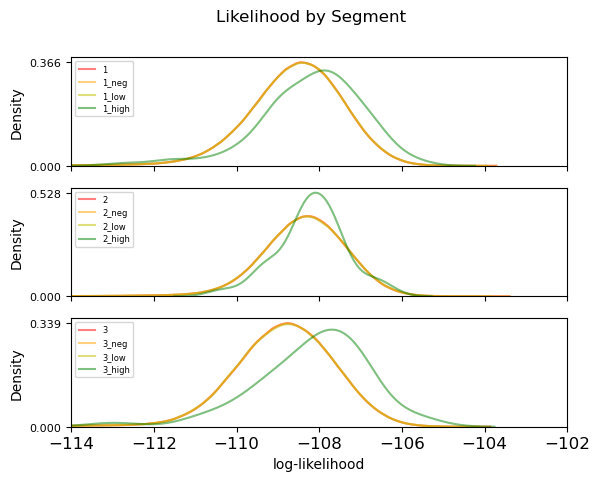

In [28]:
seg_list = [segments, segments_negative, segments_low, segments_high]
seg_list_t = [list(x) for x in zip(*seg_list)]
am.plot_likelihoods_multiple(likelihood_dict, seg_list_t, seg_list_t, title="Likelihood by Segment", xlim=(-114, -102), legend_font_size=6)

In [29]:
df_pca_kmeans.sort_values("likelihood", ascending=False, inplace=True)
df_pca_kmeans.head(200)

,sequence,copynum,round,assignment,Component 1,Component 2,Component 3,K-mean PCA Label,Segment,likelihood
2655926,TGGGGGACGAGCGGGAGGAGGTGGGATTTGCTGTT---,1.0,exosome,N,-4.358561,-1.371676,-1.496935,1,2,-103.603690
1807139,GCGGGCAGTTGCTGGTAATGTTTGTAGCGAGGAATTGA,2.0,exosome,N,0.989808,-2.224827,2.302363,0,1,-103.929924
3006096,TGTTGAGCGGTGGTTCGGACTTGGTCAGGGGGGAGGA-,1.0,exosome,N,-0.609298,-2.410286,-1.902439,0,1,-103.938887
3149511,ATATGGATAGGTCTGGGGCGAAGTGGTGTTCTGTT---,1.0,exosome,N,4.647206,-1.093324,-0.532860,2,3,-104.109156
250805,TAGGGGGGGTGGCGTGTTGGCGGTGGCTGGGGGGT---,6.0,exosome,L,-8.362175,-3.665598,-0.860361,1,2,-104.132826
...,...,...,...,...,...,...,...,...,...,...
1829462,GTTAGTATTCGGTTGGAGGGGTGTTATTGCTTGGC---,2.0,exosome,N,4.526632,-4.008387,-0.692517,2,3,-104.841576
1801403,GGGGGGATATTGATGATTAGGTGCAGGTGTTTTAC---,2.0,exosome,N,-2.262009,1.651043,-1.167748,0,1,-104.841736
357555,ATTGGGATGAGGCAAAGGGGGGAATTGTTGTGTAG---,6.0,exosome,L,-4.384479,2.755537,-1.762921,1,2,-104.845302
829307,TGGAGGAGAGGTGGGGATCAGTCTCGTCTGCAGTC---,4.0,exosome,N,0.944503,-0.237641,-1.286743,0,1,-104.845694


In [ ]:
am.plot_likelihoods()